# Overview of this Notebook

This notebook plots the feature images associated with a given subject, block, and trial on respective AOIs.

In [1]:
%load_ext autoreload
%autoreload

In [4]:
import plotly.io as pio
pio.renderers.default = 'iframe_connected'

In [3]:
import sys
import os

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as matplotlib
from matplotlib.colors import ListedColormap
import seaborn as sns
import scipy.io as io
import pandas as pd
from pandas import DataFrame, read_csv
from nivlink import Screen, Raw, Epochs, align_to_aoi, compute_fixations, plot_heatmaps
import cv2
import readline
from math import dist
from scipy.spatial.distance import squareform, pdist

import warnings
from scipy.stats import kde
import nivlink
import ipywidgets as wdg
from scipy.stats import iqr
print('Powered by NivLink' + str(nivlink.__version__))

Powered by NivLink0.2.5


In [1]:
# import custom functions
import plotAOIFeatures as paf

In [5]:
## Define global variables ##
et_data_dir = os.getcwd().strip('ldm-analysis') + 'ProcessedData/'# this expects ProcessedData to be one directory up from the analysis repo
image_dir = os.getcwd().strip('ldm-analysis') + 'FinalStimuli/ByNumber/'

## Define screen metadata.
xdim, ydim, n_screens = 1280, 1024, 1 
aoisidelength = 162
n_aois = 9

In [6]:
subj_id = 45
block = 10
trial = 1
n_trials_block = 40
## Load data.
data, raw_pos_data, messages, sfreq = paf.load_subj_data(subj_id)

## Load all centers.
all_centers = pd.read_csv(os.getcwd() + '/allCenters.csv')

## Subset this participant's centers. 
sub = 'Sub' + str(subj_id) + '_'
centers = all_centers[all_centers['Unnamed: 0'].str.contains(sub)]
centers['Block'] = [int(s.replace(sub + 'block' + '_', "")) for s in list(centers['Unnamed: 0'].values)]

## Mark run onsets. 
run_onsets = paf.get_run_onsets(messages)
n_blocks, d = run_onsets.shape

# Load feature map
featmap_file_path = et_data_dir + str(subj_id) + 'featmap.mat'
featmap_mat = io.loadmat(featmap_file_path, struct_as_record=False, squeeze_me=True)
featmap = np.array(featmap_mat["features_aoi_map"])

# Re-format events dataframe. 
events_df = paf.rereference_events(subj_id, n_blocks, run_onsets, sfreq)

# Load fixations for sub
fixations = pd.read_csv(et_data_dir + str(subj_id) + 'fixations.csv')
fixations = fixations.rename(columns={'Unnamed: 0': 'WithinBlockCount'})
# split the fixations df based on block to get a list of indices when the block number changes
grouped = fixations.groupby(fixations.WithinBlockCount)
df_getindexes = grouped.get_group(0)
index_start_list = df_getindexes.index.values.tolist()
index_start_list.append(fixations.shape[0])
if index_start_list[0] != 0:
    index_start_list.insert(0, 0)
# use list of indices to make a new column
new_col = np.ones((fixations.shape[0])).astype(int)
# subj 39, block 4 is empty
if subj_id == 39:
    for block_num in np.arange(3):
        new_col[index_start_list[block_num]:index_start_list[block_num+1]] = new_col[index_start_list[block_num]:index_start_list[block_num+1]]*(block_num+1)
    for block_num in np.arange(4,n_blocks):
        new_col[index_start_list[block_num-1]:index_start_list[block_num]] = new_col[index_start_list[block_num-1]:index_start_list[block_num]]*(block_num+1)
else: 
    for block_num in np.arange(n_blocks):
        new_col[index_start_list[block_num]:index_start_list[block_num+1]] = new_col[index_start_list[block_num]:index_start_list[block_num+1]]*(block_num+1)
fixations['BlockNumber'] = new_col

10
[0, 900, 1757, 2761, 3549, 4393, 5231, 6066, 7038, 7904, 8762]


/var/folders/pt/mk_d2k8923lbq911vprvfth00000gn/T/ipykernel_4812/4020709384.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [8]:
fixations_block = fixations[fixations.BlockNumber == block]
fixations_block_trial = fixations_block[fixations_block.Trial == (block-1)*n_trials_block + trial]

In [9]:
a = 1

In [10]:
fixations_block_trial[fixations_block_trial.AoI.astype(int) == a]

,WithinBlockCount,Trial,AoI,Onset,Offset,Duration,Feature,BlockNumber
7906,3,361.0,1.0,0.424,0.808,0.384,1.0,10
7918,17,361.0,1.0,3.088,3.208,0.120,1.0,10


In [15]:
count = 0
for index, row in fixations_block_trial.iterrows():
    print(count, '\n index ', index, "\n row ", row)
    count += 1

0 
 index  7904 
 row  WithinBlockCount      0.000
Trial               361.000
AoI                   5.000
Onset                 0.000
Offset                0.232
Duration              0.232
Feature               9.000
BlockNumber          10.000
Name: 7904, dtype: float64
1 
 index  7905 
 row  WithinBlockCount      2.00
Trial               361.00
AoI                   2.00
Onset                 0.24
Offset                0.42
Duration              0.18
Feature               8.00
BlockNumber          10.00
Name: 7905, dtype: float64
2 
 index  7906 
 row  WithinBlockCount      3.000
Trial               361.000
AoI                   1.000
Onset                 0.424
Offset                0.808
Duration              0.384
Feature               1.000
BlockNumber          10.000
Name: 7906, dtype: float64
3 
 index  7907 
 row  WithinBlockCount      5.000
Trial               361.000
AoI                  10.000
Onset                 0.816
Offset                0.824
Duration              0

/Users/Naiti/Documents/Documents_NBMacBookPro/NYU/EyetrackingProject/ldm-analysis/plotAOIFeatures.py:186: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(<Figure size 270x216 with 2 Axes>, <AxesSubplot:>)

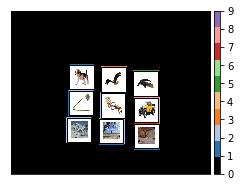

In [6]:
paf.plotAOIFeatures(39, 1, 3)